# Systemy Uczące Się - Algorytmy klasyfikacji
### Belkius Grzegorz
## Wstęp
Wykorzystanie oraz porównanie 4 algorytmów klasyfikacyjncyh na przykładzie zbioru danych dotyczącego diagnozy raka piersi. Algorytmy zostaną zaimplementowane z wykorzystaniem Pythona oraz biblioteki scikit-learn.

Zbiór danych dostępny pod linkiem (01.06.2024):
https://www.kaggle.com/datasets/erdemtaha/cancer-data

Porównywane algorytmy:
* Logsitic Regression
* KNN
* Decision Tree Classifier
* XGBoost

## Definicja problemu
Czy posiadając dane na temat wizualnego obrazu jąder komórek rakowych, jesteśmy w stanie określić czy nowotwór jest złośliwy czy też nie?

## O zbiorze danych
Cechy są obliczane z cyfrowego obrazu aspiratu cienkoigłowego (FNA) masy piersiowej. Opisują one charakterystyki jąder komórkowych obecnych na obrazie.

Informacje o atrybutach:

1. Numer ID
2. Diagnoza (M = złośliwy, B = łagodny)
3.-32. Dziesięć cech rzeczywistych jest obliczanych dla każdego jądra komórkowego:\
a) promień (średnia odległości od środka do punktów na obwodzie)\
b) tekstura (odchylenie standardowe wartości w skali szarości)\
c) obwód\
d) powierzchnia\
e) gładkość (lokalne zróżnicowanie długości promienia)\
f) zwartość (obwód^2 / powierzchnia - 1.0)\
g) wklęsłość (stopień wklęsłych części konturu)\
h) punkty wklęsłe (liczba wklęsłych części konturu)\
i) symetria\
j) wymiar fraktalny ("przybliżenie linii brzegowej" - 1)\
Średnia, błąd standardowy i "najgorsza" lub największa (średnia z trzech największych wartości) z tych cech zostały obliczone dla każdego obrazu, co daje łącznie 30 cech. Na przykład pole 3 to średni promień, pole 13 to promień SE, pole 23 to najgorszy promień.\
Wszystkie wartości cech są zapisane z dokładnością do czterech cyfr znaczących.

Rozkład klas: 357 niezłośliwych, 212 złośliwych


## Rozwiązanie problemu

In [ ]:
# @title Zaimportowanie bibliotek oraz danych { display-mode: "form" }
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Przeprowadzenie wstępnej analizy zbioru.

In [ ]:
#@title Przejrzenie przykładowych danych { display-mode: "form" }
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/systemy uczace sie/Cancer_Data.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,NaN
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,NaN
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,NaN
3,84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,NaN
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,NaN


In [ ]:
#@title Informacje dotyczące kolumn { display-mode: "form" }
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
#@title Kształt tablicy zbioru danych { display-mode: "form" }
data.shape

(569, 33)

## Wykres zestawiający ilość diagnoz złośliwych (M) oraz ilość diagnoz niezłośliwych (B).
Możemy zauważyć przewagę diagnoz znaczącą niezłośliwych, co może wpłynąć na skuteczność tworzonych przez nas modeli. Jednakże mniejsza ilość diagnoz złośliwych, przy takich ilościach, może działać na naszą korzyść, ponieważ niektóre z algorytmów będą bardziej wyczulone na anomalie w postaci raka złośliwego. Bardziej zależy nam na minimalizacji fałszywych negatywnych wyników przy wykrywaniu raka złośliwego, niż na minimalizacji fałszywie pozytywnych.  

In [ ]:
# @title { display-mode: "form" }
data.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [ ]:
# @title { display-mode: "form" }
data.diagnosis.value_counts()

fig = px.bar(data, x='diagnosis', title="Breast Cancer Count")
fig.update_xaxes(title_text='Cancer type')
fig.update_yaxes(title_text='Count')
fig.update_layout(width=500, height=350)

fig.show()

### Czyszczenie i normalizacja danych

*   Usunięcie danych "Unnamed", ponieważ nie wnoszą żadnych informacji  oraz "id", ze względu na bardziej dogodne wykorzystanie automatycznego indeksowania biblioteki.
*   Zmiana wartości diagnozy kolejno z liter "M" oraz "B" na wartości 1 oraz 0.


In [ ]:
# @title  { display-mode: "form" }
data.drop(["Unnamed: 32","id"],axis=1,inplace = True)
data.diagnosis = [1 if each == "M" else 0 for each in data.diagnosis]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [ ]:
# @title Analiza rozłożenia wartości w zestawie danych { display-mode: "form" }
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,0.37,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,...,16.27,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08
std,0.48,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,...,4.83,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02
min,0.00,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,...,7.93,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06
25%,0.00,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,...,13.01,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07
50%,0.00,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,...,14.97,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08
75%,1.00,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,...,18.79,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09
max,1.00,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,...,36.04,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21


In [ ]:
# @title Sprawdzenie czy nie zmieniliśmy struktury danych { display-mode: "form" }
data.diagnosis.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [ ]:
# @title { display-mode: "form" }

fig = px.bar(data.diagnosis.value_counts(), x='count', title="Breast Cancer Count")
fig.update_xaxes(title_text='Cancer type')
fig.update_yaxes(title_text='Count')
fig.update_layout(width=500, height=350)

fig.show()

In [ ]:
# @title Wyświetlenie ilości brakujących dla konkretnych kolumn wartości. { display-mode: "form" }
data.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Już wcześniej wspomniano, iż zbiór danych nie jest idealnie zbalansowany, lecz nie są to na tyle istotne różnice, aby wpłynęły na szkolenie algorytmów oraz przetestowanie metody klasyfikacji w naszym problemie. \
Możemy również zauważyć, że w zbiorze nie ma wartości null w związku z czym nie musimy ich wypełniać lub usuwać rekordy.

### Sprawdznie rodzaji danych w zbiorze
Możemy zauważyć, że jedyną wartością, która nie jest ciągła jest wartość diagnozy. Możnabyło to również wywnioskować z opisu pozostałych wartości lub przeglądając przykładowe dane, lecz teraz mamy pewność.

In [ ]:
# @title { display-mode: "form" }
categorical_val = []
continous_val = []
for column in data.columns:
    if len(data[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

print("Wartości kategoryczne:")
categorical_val

Wartości kategoryczne:


['diagnosis']

In [ ]:
# @title { display-mode: "form" }
dataset = pd.get_dummies(data, columns = categorical_val)

In [ ]:
# @title { display-mode: "form" }
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,...,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,1,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,...,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,1,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,...,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,1,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,...,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,1,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,...,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [ ]:
print(data.columns)
print(dataset.columns)

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_

### Standaryzacja danych z wykorzystaniem standardowej skali.
Dzięki ustandaryzowaniu wszystkich kolumn do podobnej skali uzyskamy:
* Lepsza wydajność algorytmów: Wiele algorytmów uczenia maszynowego, takich jak SVM, k-NN, czy regresja logistyczna, działa lepiej, gdy dane są standaryzowane. Wynika to z faktu, że te algorytmy bazują na odległościach w przestrzeni cech, a różne skale danych mogą zniekształcać te odległości, prowadząc do nieoptymalnych wyników.
* Uniknięcie dominacji cech o większych wartościach: Jeśli jedna cecha ma dużo większą skalę niż inne, może zdominować funkcję kosztu i wpłynąć na wyniki modelu. Standaryzacja sprawia, że każda cecha ma równy wkład w model.
* Stabilność numeryczna: Standaryzacja może poprawić stabilność numeryczną obliczeń. W przypadku bardzo dużych lub bardzo małych wartości, operacje matematyczne mogą prowadzić do błędów numerycznych.

In [ ]:
# @title { display-mode: "form" }
from sklearn.preprocessing import StandardScaler

s_sc = StandardScaler()
col_to_scale = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst']
dataset[col_to_scale] = s_sc.fit_transform(dataset[col_to_scale])

In [ ]:
dataset.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_0,diagnosis_1
0,1.10,-2.07,1.27,0.98,0.12,0.28,0.30,0.15,0.24,0.08,...,2.30,2.00,0.16,0.67,0.71,0.27,0.46,0.12,False,True
1,1.83,-0.35,1.69,1.91,0.08,0.08,0.09,0.07,0.18,0.06,...,1.54,1.89,0.12,0.19,0.24,0.19,0.28,0.09,False,True
2,1.58,0.46,1.57,1.56,0.11,0.16,0.20,0.13,0.21,0.06,...,1.35,1.46,0.14,0.42,0.45,0.24,0.36,0.09,False,True
3,-0.77,0.25,-0.59,-0.76,0.14,0.28,0.24,0.11,0.26,0.10,...,-0.25,-0.55,0.21,0.87,0.69,0.26,0.66,0.17,False,True
4,1.75,-1.15,1.78,1.83,0.10,0.13,0.20,0.10,0.18,0.06,...,1.34,1.22,0.14,0.20,0.40,0.16,0.24,0.08,False,True


### Zestawienie wykresów wszystkich cech z podziałem na diagnozy
Z wykresów możemy określić, iż większość wartości uśrednionych oraz najgorszych wykazuje znaczące różnice w zależności od diagnozy. Mimo, że wartości SE nie wykazują tak znaczących różnic zostaną one wykorzystane przy szkoleniu algorytmów.

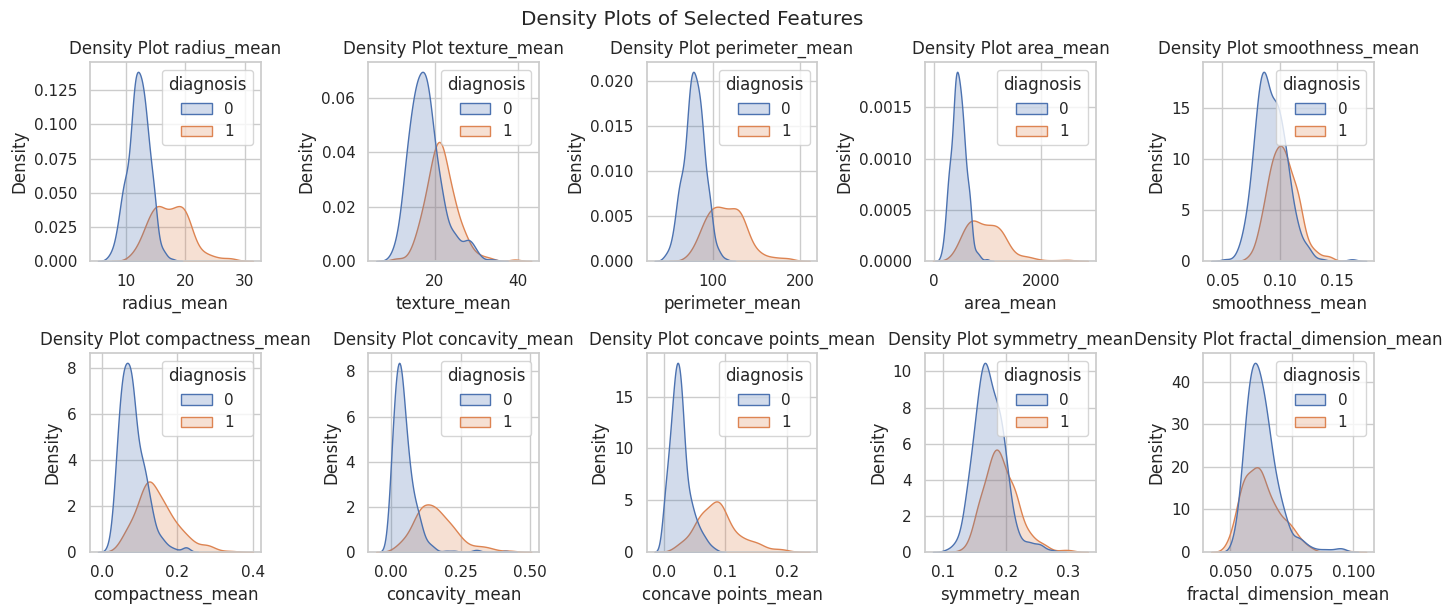

In [ ]:
# @title { display-mode: "form" }
sns.set(style="whitegrid")
selected_features = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean",
                     "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean",
                     "symmetry_mean", "fractal_dimension_mean"]
plt.figure(figsize=(14, 6))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(data=data, x=feature, hue='diagnosis', fill=True)
    plt.title(f'Density Plot {feature}')
plt.tight_layout()
plt.suptitle('Density Plots of Selected Features', y=1.02)
plt.show()

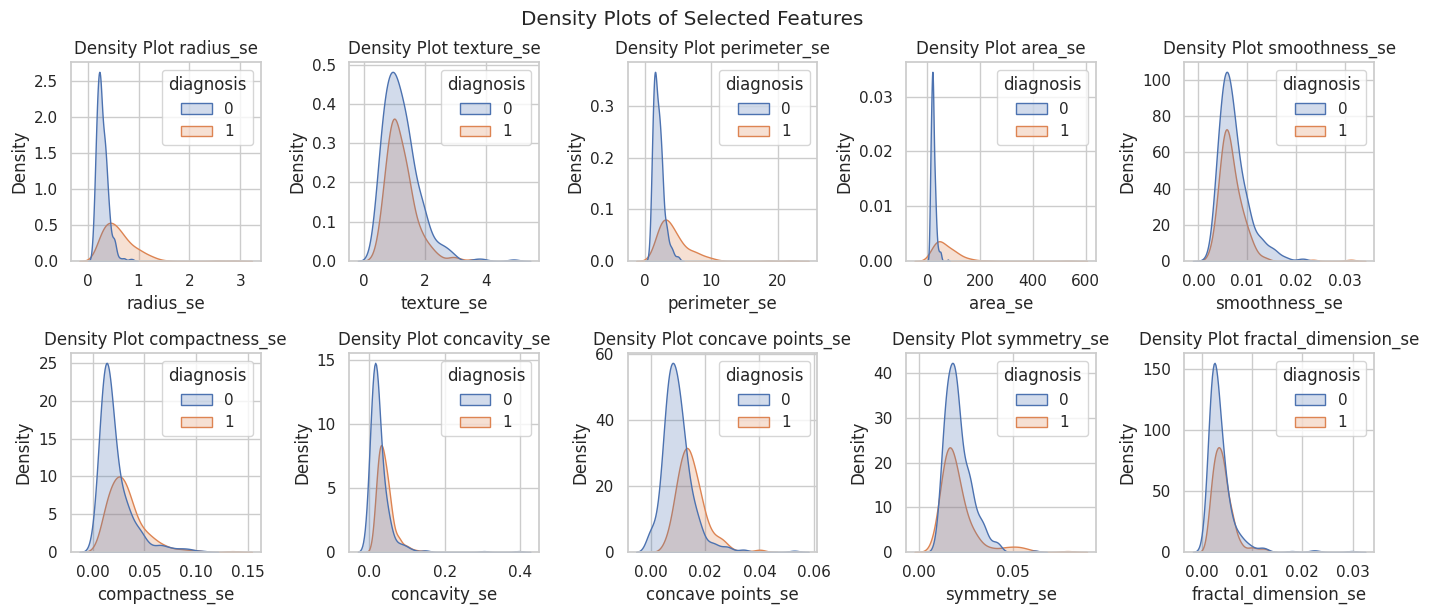

In [ ]:
# @title { display-mode: "form" }
sns.set(style="whitegrid")
selected_features = ["radius_se", "texture_se", "perimeter_se", "area_se","smoothness_se",
                     "compactness_se", "concavity_se", "concave points_se", "symmetry_se",
                     "fractal_dimension_se"]
plt.figure(figsize=(14, 6))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(data=data, x=feature, hue='diagnosis', fill=True)
    plt.title(f'Density Plot {feature}')
plt.tight_layout()
plt.suptitle('Density Plots of Selected Features', y=1.02)
plt.show()

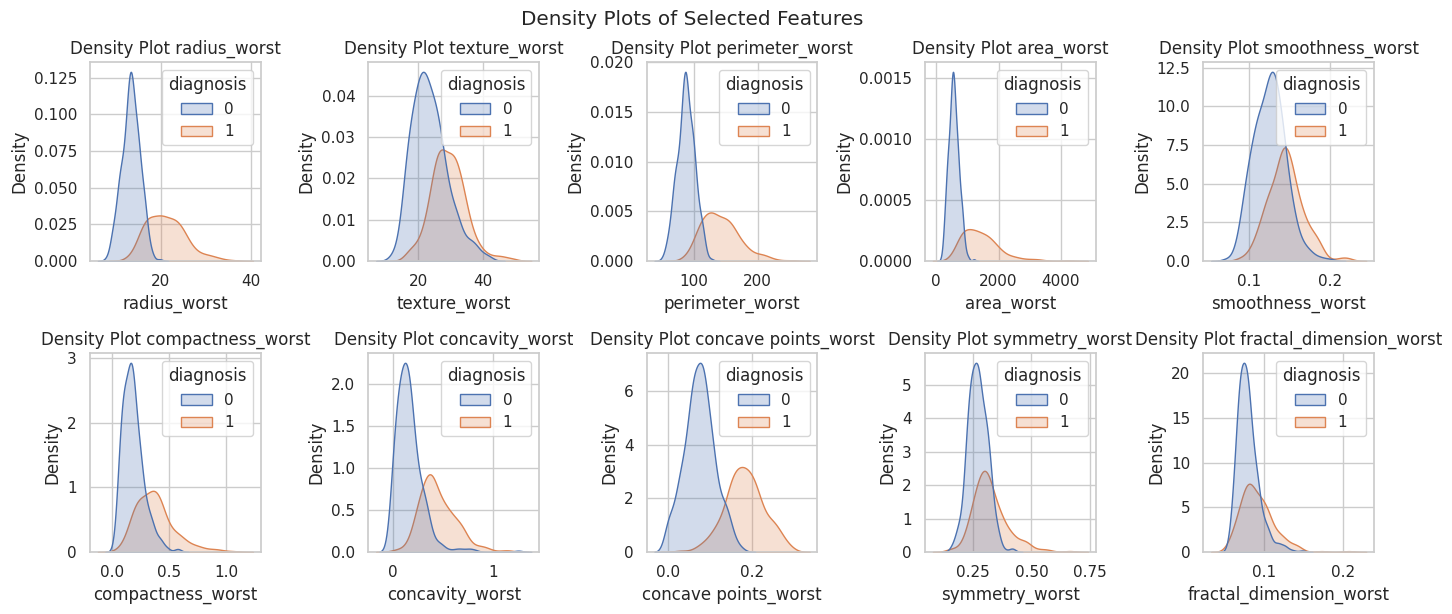

In [ ]:
# @title { display-mode: "form" }
sns.set(style="whitegrid")
selected_features = ["radius_worst", "texture_worst", "perimeter_worst", "area_worst",
                     "smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst",
                     "symmetry_worst", "fractal_dimension_worst"]
plt.figure(figsize=(14, 6))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(data=data, x=feature, hue='diagnosis', fill=True)
    plt.title(f'Density Plot {feature}')
plt.tight_layout()
plt.suptitle('Density Plots of Selected Features', y=1.02)
plt.show()

## Trenowanie algorytmów klasyfikacyjnych
Poniżej wytrenowano 4 algorytmy klasyfikacji z równoczesną optymalizacją pod względem pewnych parametrów:
* Logsitic Regression
* KNN
* Decision Tree Classifier
* XGBoost

W podsumowaniu przedstawiono tabelę porównującą dokładność każdego z algorytmów na danych treningowych oraz na danych testowych./
Przy każdym z przeszkolonych algorytmów został wyświetlony raport z klasyfikacji oraz tablica kontyngencji dla danych treningowych i testowych.


In [ ]:
# @title { display-mode: "form" }
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n_______________________________________________")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n_______________________________________________")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [ ]:
# @title { display-mode: "form" }
from sklearn.model_selection import train_test_split

X = data.drop('diagnosis', axis=1)
y = data.diagnosis

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression
Logistyczna regresja jest popularnym algorytmem stosowanym do problemów klasyfikacji, który jest szczególnie użyteczny, gdy mamy do czynienia z danymi binarnymi, czyli takimi, które mogą przyjmować jedną z dwóch możliwych wartości. W przeciwieństwie do regresji liniowej, logistyczna regresja przewiduje prawdopodobieństwo wystąpienia jednej z dwóch klas, używając funkcji logistycznej (sigmoid) do transformacji wartości wyjściowej.

Przeszkolone zostały 3 algorytmy regresji logistycznej z wyróżnieniem 3 różnych algorytmów rozwiązujących:
* Liblinear Solver
* Newton-cg Solver
* Sag Solver

Najlepszymi wynikami przy rozwiązywaniu naszego problemu okazał się algorytm rozwiązujący Newton-cg.

In [ ]:
# @title Liblinear Solver { display-mode: "form" }
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 95.23%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.95   0.95      0.95       0.95          0.95
recall      0.97   0.92      0.95       0.95          0.95
f1-score    0.96   0.94      0.95       0.95          0.95
support   249.00 149.00      0.95     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[242   7]
 [ 12 137]]

Test Result:
_______________________________________________
Accuracy Score: 96.49%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.96  0.97      0.96       0.97          0.96
recall      0.98  0.94      0.96       0.96          0.96
f1-score    0.97  0.95      0.96       0.96          0.96
support   108.00 63.00      0.96     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df = pd.DataFrame(data=[["Logistic Regression Liblinear", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

In [ ]:
# @title Newton-cg Solver { display-mode: "form" }
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='newton-cg')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 95.98%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.96   0.96      0.96       0.96          0.96
recall      0.98   0.93      0.96       0.95          0.96
f1-score    0.97   0.95      0.96       0.96          0.96
support   249.00 149.00      0.96     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[243   6]
 [ 10 139]]

Test Result:
_______________________________________________
Accuracy Score: 97.66%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.98  0.97      0.98       0.97          0.98
recall      0.98  0.97      0.98       0.97          0.98
f1-score    0.98  0.97      0.98       0.97          0.98
support   108.00 63.00      0.98     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Logistic Regression Newton-cg", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Sag Solver { display-mode: "form" }
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='sag')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 90.45%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.89   0.94      0.90       0.91          0.91
recall      0.97   0.80      0.90       0.88          0.90
f1-score    0.93   0.86      0.90       0.89          0.90
support   249.00 149.00      0.90     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[241   8]
 [ 30 119]]

Test Result:
_______________________________________________
Accuracy Score: 94.74%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.94  0.97      0.95       0.95          0.95
recall      0.98  0.89      0.95       0.94          0.95
f1-score    0.96  0.93      0.95       0.94          0.95
support   108.00 63.00      0.95     171.00        171.00
____________

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Logistic Regression sag", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression Liblinear,95.23,96.49
1,Logistic Regression Newton-cg,95.98,97.66
2,Logistic Regression sag,90.45,94.74


## K-nearest neighbour
K-najbliższych sąsiadów (KNN) to prosty algorytm klasyfikacji, który przewiduje klasy dla nowych próbek na podstawie etykiet najbliższych sąsiadów w przestrzeni cech. Algorytm ten jest oparty na założeniu, że podobne próbki powinny mieć podobne etykiety. W przypadku klasyfikacji, kiedy nowa próbka jest poddawana predykcji, algorytm znajduje K najbliższych sąsiadów tej próbki w przestrzeni cech, a następnie przewiduje etykietę na podstawie dominującej klasy wśród tych sąsiadów.

Przeszkolone zostały 3 algorytmy z rozróżnieniem pod względem sąsiadów:
* Liczba sąsiadów 9
* Liczba sąsiadów 11
* Liczba sąsiadów 13

Najlepszymi wynikami przy rozwiązywaniu naszego problemu okazał się algorytm z liczbą sąsiadów równą 11.

In [ ]:
# @title Number of neighbors = 9 { display-mode: "form" }
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=9)
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 92.21%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.91   0.94      0.92       0.93          0.92
recall      0.97   0.85      0.92       0.91          0.92
f1-score    0.94   0.89      0.92       0.92          0.92
support   249.00 149.00      0.92     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[241   8]
 [ 23 126]]

Test Result:
_______________________________________________
Accuracy Score: 97.08%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.96  0.98      0.97       0.97          0.97
recall      0.99  0.94      0.97       0.96          0.97
f1-score    0.98  0.96      0.97       0.97          0.97
support   108.00 63.00      0.97     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors n=9", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Number of neighbors = 11 { display-mode: "form" }
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=11)
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 92.21%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.91   0.95      0.92       0.93          0.92
recall      0.97   0.84      0.92       0.91          0.92
f1-score    0.94   0.89      0.92       0.91          0.92
support   249.00 149.00      0.92     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[242   7]
 [ 24 125]]

Test Result:
_______________________________________________
Accuracy Score: 97.66%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.97  0.98      0.98       0.98          0.98
recall      0.99  0.95      0.98       0.97          0.98
f1-score    0.98  0.97      0.98       0.97          0.98
support   108.00 63.00      0.98     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors n=11", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Number of neighbors = 13 { display-mode: "form" }
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=13)
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 91.96%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.91   0.95      0.92       0.93          0.92
recall      0.97   0.83      0.92       0.90          0.92
f1-score    0.94   0.89      0.92       0.91          0.92
support   249.00 149.00      0.92     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[242   7]
 [ 25 124]]

Test Result:
_______________________________________________
Accuracy Score: 96.49%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.96  0.98      0.96       0.97          0.97
recall      0.99  0.92      0.96       0.96          0.96
f1-score    0.97  0.95      0.96       0.96          0.96
support   108.00 63.00      0.96     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors n=13", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression Liblinear,95.23,96.49
1,Logistic Regression Newton-cg,95.98,97.66
2,Logistic Regression sag,90.45,94.74
3,K-nearest neighbors n=9,92.21,97.08
4,K-nearest neighbors n=11,92.21,97.66
5,K-nearest neighbors n=13,91.96,96.49


## Decision Tree Classifier
Drzewa decyzyjne są popularnymi modelami klasyfikacyjnymi, które działają na zasadzie serii pytań-wartości logicznych, które prowadzą do końcowej klasy lub wartości docelowej. Każdy węzeł w drzewie reprezentuje test na jednej z cech danych, a każda krawędź z węzła do jego potomków odpowiada wynikowi tego testu. Proces ten kontynuuje się, aż dotrzemy do liścia, który reprezentuje końcową klasę lub wartość przewidywaną dla danej próbki.

Przeszkolone zostały 3 algorytmy z rozróżnieniem pod względem minimalnej liczby próbek w liściu:
* Liczba próbek 1
* Liczba próbek 2
* Liczba próbek 3

Najlepszymi wynikami przy rozwiązywaniu naszego problemu okazał się algorytm z minimalnej liczby próbek w liściu równą 2.\
Przy liczbie próbek równej 1 można zauważyć przetrenowanie modelu z 100% skutecznością.

In [ ]:
# @title Minimum sample leaf = 1 { display-mode: "form" }
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(min_samples_leaf=1)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   1.00   1.00      1.00       1.00          1.00
recall      1.00   1.00      1.00       1.00          1.00
f1-score    1.00   1.00      1.00       1.00          1.00
support   249.00 149.00      1.00     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[249   0]
 [  0 149]]

Test Result:
_______________________________________________
Accuracy Score: 92.98%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.97  0.87      0.93       0.92          0.93
recall      0.92  0.95      0.93       0.93          0.93
f1-score    0.94  0.91      0.93       0.93          0.93
support   108.00 63.00      0.93     171.00        171.00
___________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier leaf=1", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Minimum sample leaf = 2 { display-mode: "form" }
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(min_samples_leaf=2)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 98.99%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.99   0.99      0.99       0.99          0.99
recall      1.00   0.98      0.99       0.99          0.99
f1-score    0.99   0.99      0.99       0.99          0.99
support   249.00 149.00      0.99     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[248   1]
 [  3 146]]

Test Result:
_______________________________________________
Accuracy Score: 97.08%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.98  0.95      0.97       0.97          0.97
recall      0.97  0.97      0.97       0.97          0.97
f1-score    0.98  0.96      0.97       0.97          0.97
support   108.00 63.00      0.97     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier leaf=2", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Minimum sample leaf = 3 { display-mode: "form" }
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(min_samples_leaf=3)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 98.74%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.98   0.99      0.99       0.99          0.99
recall      1.00   0.97      0.99       0.98          0.99
f1-score    0.99   0.98      0.99       0.99          0.99
support   249.00 149.00      0.99     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[248   1]
 [  4 145]]

Test Result:
_______________________________________________
Accuracy Score: 95.91%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.96  0.95      0.96       0.96          0.96
recall      0.97  0.94      0.96       0.95          0.96
f1-score    0.97  0.94      0.96       0.96          0.96
support   108.00 63.00      0.96     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier leaf=3", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression Liblinear,95.23,96.49
1,Logistic Regression Newton-cg,95.98,97.66
2,Logistic Regression sag,90.45,94.74
3,K-nearest neighbors n=9,92.21,97.08
4,K-nearest neighbors n=11,92.21,97.66
5,K-nearest neighbors n=13,91.96,96.49
6,Decision Tree Classifier leaf=1,100.00,92.98
7,Decision Tree Classifier leaf=2,98.99,97.08
8,Decision Tree Classifier leaf=3,98.74,95.91


## XGBoost
XGBoost (eXtreme Gradient Boosting) to zaawansowana technika uczenia maszynowego, która wykorzystuje algorytm gradientowego wzmacniania do budowy silnych modeli predykcyjnych. Jest to efektywna metoda ensemble, która łączy wiele słabych modeli (np. drzew decyzyjnych) w celu stworzenia silnego modelu predykcyjnego.

Przeszkolone zostały 3 algorytmy z rozróżnieniem pod względem liczby estymatorów:
* Liczba estymatorów 7
* Liczba estymatorów 8
* Liczba estymatorów 9

Najlepszymi wynikami przy rozwiązywaniu naszego problemu okazał się algorytm z liczbą estymatorów równą 8.

In [ ]:
# @title Estimators = 7 { display-mode: "form" }
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, n_estimators=7)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 99.50%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.99   1.00      0.99       1.00          1.00
recall      1.00   0.99      0.99       0.99          0.99
f1-score    1.00   0.99      0.99       0.99          0.99
support   249.00 149.00      0.99     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[249   0]
 [  2 147]]

Test Result:
_______________________________________________
Accuracy Score: 97.08%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.97  0.97      0.97       0.97          0.97
recall      0.98  0.95      0.97       0.97          0.97
f1-score    0.98  0.96      0.97       0.97          0.97
support   108.00 63.00      0.97     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier est=7", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Estimators = 8 { display-mode: "form" }
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, n_estimators=8)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 99.50%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.99   1.00      0.99       1.00          1.00
recall      1.00   0.99      0.99       0.99          0.99
f1-score    1.00   0.99      0.99       0.99          0.99
support   249.00 149.00      0.99     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[249   0]
 [  2 147]]

Test Result:
_______________________________________________
Accuracy Score: 97.66%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.98  0.97      0.98       0.97          0.98
recall      0.98  0.97      0.98       0.97          0.98
f1-score    0.98  0.97      0.98       0.97          0.98
support   108.00 63.00      0.98     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier est=8", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)

In [ ]:
# @title Estimators = 9 { display-mode: "form" }
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, n_estimators=9)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
_______________________________________________
Accuracy Score: 99.50%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision   0.99   1.00      0.99       1.00          1.00
recall      1.00   0.99      0.99       0.99          0.99
f1-score    1.00   0.99      0.99       0.99          0.99
support   249.00 149.00      0.99     398.00        398.00
_______________________________________________
Confusion Matrix: 
 [[249   0]
 [  2 147]]

Test Result:
_______________________________________________
Accuracy Score: 96.49%
_______________________________________________
Classification Report:
               0     1  accuracy  macro avg  weighted avg
precision   0.96  0.97      0.96       0.97          0.96
recall      0.98  0.94      0.96       0.96          0.96
f1-score    0.97  0.95      0.96       0.96          0.96
support   108.00 63.00      0.96     171.00        171.00
____________

In [ ]:
# @title { display-mode: "form" }
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier est=9", train_score, test_score]],
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, pd.DataFrame(results_df_2)], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression Liblinear,95.23,96.49
1,Logistic Regression Newton-cg,95.98,97.66
2,Logistic Regression sag,90.45,94.74
3,K-nearest neighbors n=9,92.21,97.08
4,K-nearest neighbors n=11,92.21,97.66
5,K-nearest neighbors n=13,91.96,96.49
6,Decision Tree Classifier leaf=1,100.00,92.98
7,Decision Tree Classifier leaf=2,98.99,97.08
8,Decision Tree Classifier leaf=3,98.74,95.91
9,XGBoost Classifier est=7,99.50,97.08


## Podsumowanie
Po przejerzeniu wyników wszystkich modeli, można stwierdzić, iż wszystkie algorytmy w zadowalającym stopniu sprawdziły się przy rozwiązywaniu zadanego problemu. \
Po dopasowaniu odpowiednich testowanych parametrów, znaleźli dosyć zoptymalizowane rozwiązania przy każdym algorytmie. Warto zauważyć, że przy jednym z nich, Decision Tree Classifier, natknęliśmy się na problem przetrenowania, gdzie łatwo zauważyć 100% wartość dokładności przy trenowaniu, a dokładność na zbiorze testowym się pogorszyła w porównaniu do pozostałych parametrów.\
Jak można odczytać z poniższej tabeli oraz wykresu, najlepiej poradził sobie algorytm XGBoost, K-nearest neighbors  oraz Logsitic Regression Newton-CG.\
Nie oznacza to, że pozostałe algorytmy poradziły sobie źle, biorąc pod uwagę, iż wszystkie algorytmy miały skuteczność na zbiorze testowym na poziomie ponad 95%, można założyć, że klasyfikacja naszego problemu jest możliwa przy użyciu algorytmów uczenia maszynowego.


In [ ]:
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression Liblinear,95.23,96.49
1,Logistic Regression Newton-cg,95.98,97.66
2,Logistic Regression sag,90.45,94.74
3,K-nearest neighbors n=9,92.21,97.08
4,K-nearest neighbors n=11,92.21,97.66
5,K-nearest neighbors n=13,91.96,96.49
6,Decision Tree Classifier leaf=1,100.00,92.98
7,Decision Tree Classifier leaf=2,98.99,97.08
8,Decision Tree Classifier leaf=3,98.74,95.91
9,XGBoost Classifier est=7,99.50,97.08


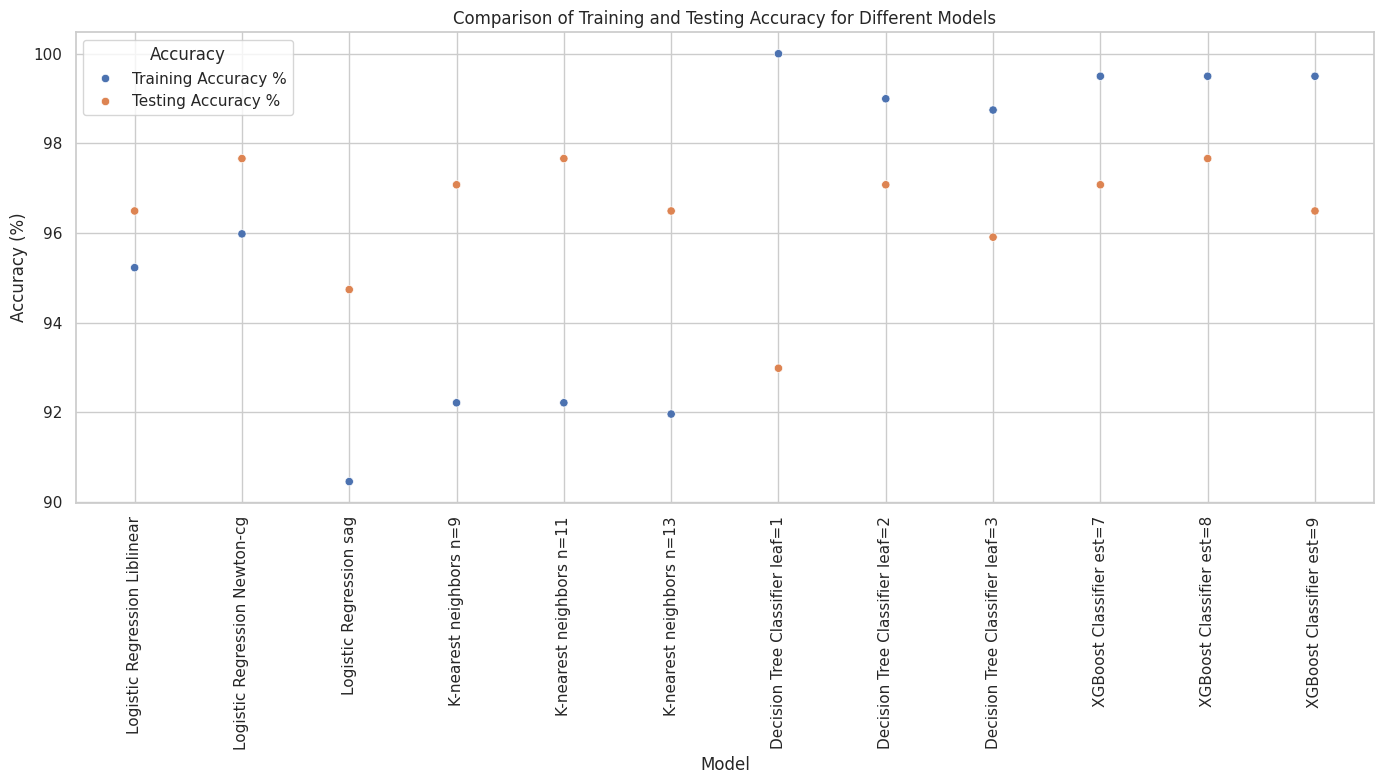

In [ ]:
# @title Porównanie wyników wszystkich modeli w postaci wykresu { display-mode: "form" }
plt.figure(figsize=(14, 8))
sns.scatterplot(data=results_df.melt(id_vars='Model', value_vars=['Training Accuracy %', 'Testing Accuracy %']),
             x='Model', y='value', hue='variable', marker='o')

plt.title('Comparison of Training and Testing Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=90)
plt.legend(title='Accuracy')
plt.tight_layout()

plt.show()